# Cluster Analysis

### Task Description
To better understand what typical charging sessions look like, carry out a cluster
analysis to provide management with a succinct report of archetypical charging events. Think of an
appropriate trade-off between explainability and information content and try to come up with names
for these clusters. What is the value of identifying different types of charging sessions?

In [1]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'scipy'

### Data Prep

In [ ]:
df_charging_sessions = pd.read_csv("charging_sessions_preprocessed.csv",  parse_dates=['connectionTime','disconnectTime','doneChargingTime']);
# convert to local time
df_charging_sessions["connectionTime"] = df_charging_sessions["connectionTime"].dt.tz_convert("America/Los_Angeles")
df_charging_sessions["disconnectTime"] = df_charging_sessions["disconnectTime"].dt.tz_convert("America/Los_Angeles")
df_charging_sessions["doneChargingTime"] = df_charging_sessions["doneChargingTime"].dt.tz_convert("America/Los_Angeles")
print(df_charging_sessions.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   id                   66450 non-null  object                             
 1   connectionTime       66450 non-null  datetime64[ns, America/Los_Angeles]
 2   disconnectTime       66450 non-null  datetime64[ns, America/Los_Angeles]
 3   doneChargingTime     66450 non-null  datetime64[ns, America/Los_Angeles]
 4   kWhDelivered         66450 non-null  float64                            
 5   sessionID            66450 non-null  object                             
 6   siteID               66450 non-null  int64                              
 7   spaceID              66450 non-null  object                             
 8   stationID            66450 non-null  object                             
 9   userID               49187 n

In [ ]:
print(len(df_charging_sessions))
charging_sessions_clustering = df_charging_sessions.copy()
charging_sessions_clustering = charging_sessions_clustering.drop_duplicates()
print(len(charging_sessions_clustering))

66450
65037


In [ ]:
print(len(charging_sessions_clustering['sessionID'].unique()))
print(len(charging_sessions_clustering['sessionID']))

65037
65037


After dropping the duplicates, sessionIDs are unique.

For the cluster analysis, we include the weather data as it could provide important information about the types of charging sessions.
We merge the two datasets based on the day and hour the charging session started, as we only have hourly information about the weather. We analyse the temperature and the description of the cloud cover. With this information, we know if, for example, it was cold and rainy during a charging session.

In [ ]:
# read in weather data
weather_set = pd.read_csv('weather_burbank_airport_preprocessed.csv', parse_dates=['timestamp'])

# 'timestamp' in datetime umwandeln und Zeitzone zuweisen
weather_set['timestamp'] = pd.to_datetime(weather_set['timestamp']).dt.tz_localize('UTC').dt.tz_convert('America/Los_Angeles')

# Ergebnisse anzeigen
print(weather_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype                              
---  ------                   --------------  -----                              
 0   timestamp                29244 non-null  datetime64[ns, America/Los_Angeles]
 1   temperature              29244 non-null  float64                            
 2   cloud_cover              29244 non-null  float64                            
 3   cloud_cover_description  29244 non-null  object                             
 4   pressure                 29244 non-null  float64                            
 5   windspeed                29244 non-null  float64                            
 6   precipitation            29244 non-null  float64                            
 7   felt_temperature         29244 non-null  float64                            
dtypes: datetime64[ns, America/Los_Angeles](1), float64(6), object(1)
me

In [ ]:
# drop columns that are not needed
weather_set = weather_set.drop(['cloud_cover', 'cloud_cover_description','pressure', 'windspeed', 'felt_temperature'], axis=1)
print(weather_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype                              
---  ------         --------------  -----                              
 0   timestamp      29244 non-null  datetime64[ns, America/Los_Angeles]
 1   temperature    29244 non-null  float64                            
 2   precipitation  29244 non-null  float64                            
dtypes: datetime64[ns, America/Los_Angeles](1), float64(2)
memory usage: 685.5 KB
None


In [ ]:
weather_set['connectionDate'] = weather_set['timestamp'].dt.date
weather_set['connectionHour'] = weather_set['timestamp'].dt.hour
days_unique = weather_set['connectionDate'].unique()
days = np.repeat(days_unique,24)
hours = list(range(0,24))
hours = hours*len(days_unique)

weather_hourly = pd.DataFrame()
weather_hourly['connectionDate'] = days
weather_hourly['connectionHour'] = hours
print(len(weather_hourly))
print(weather_hourly)

26280
      connectionDate  connectionHour
0         2018-01-01               0
1         2018-01-01               1
2         2018-01-01               2
3         2018-01-01               3
4         2018-01-01               4
...              ...             ...
26275     2020-12-31              19
26276     2020-12-31              20
26277     2020-12-31              21
26278     2020-12-31              22
26279     2020-12-31              23

[26280 rows x 2 columns]


In [ ]:
# add columns temperature and precipitation
# if they are several values for an hour of a day, mean is caluclated
temperature = []
precipitation = []
for index, row in weather_hourly.iterrows():
    searched_day = row['connectionDate']
    searched_hour = row['connectionHour']
    temperatures_of_hour = weather_set[(weather_set['connectionDate']==searched_day) & (weather_set['connectionHour']==searched_hour)]['temperature']
    temperature.append(temperatures_of_hour.mean())
    precipitation_of_hour = weather_set[(weather_set['connectionDate']==searched_day) & (weather_set['connectionHour']==searched_hour)]['precipitation']
    precipitation.append(precipitation_of_hour.mean())

weather_hourly['temperature'] = temperature
weather_hourly['precipitation'] = precipitation
print(weather_hourly.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   connectionDate  26280 non-null  object 
 1   connectionHour  26280 non-null  int64  
 2   temperature     26210 non-null  float64
 3   precipitation   26210 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 821.4+ KB
None


We have some Null values for temperature and perceptibility. This is due to missing data in the weather dataset. The set does not contain information for every hour of every day. For these hours we calculate the average of the day and replace the Null values with the result.

# Verbesserung:
Wert zuvor bzw zuletzt nehmen

In [ ]:
def fill_in_mean_of_day(df,column):
    for index, row in df.iterrows():
        value = row[column]
        if pd.isna(value):
            day_of_null = row['connectionDate']
            mean_of_day = df[df['connectionDate']==day_of_null][column].mean()
            df.loc[index, column] = mean_of_day
    return df  

In [ ]:
weather_hourly_cleaned = fill_in_mean_of_day(weather_hourly, 'temperature')
weather_hourly_cleaned = fill_in_mean_of_day(weather_hourly, 'precipitation')
print(weather_hourly_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   connectionDate  26280 non-null  object 
 1   connectionHour  26280 non-null  int64  
 2   temperature     26280 non-null  float64
 3   precipitation   26280 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 821.4+ KB
None


In [ ]:
# add columns for merging
charging_sessions_clustering['connectionDate'] = charging_sessions_clustering['connectionTime'].dt.date
charging_sessions_clustering['connectionHour'] = charging_sessions_clustering['connectionTime'].dt.hour

In [ ]:
# left merge
df_charging_sessions_weather = charging_sessions_clustering.merge(weather_hourly_cleaned, how='left', on=['connectionDate', 'connectionHour'])
print(df_charging_sessions_weather.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65037 entries, 0 to 65036
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   id                   65037 non-null  object                             
 1   connectionTime       65037 non-null  datetime64[ns, America/Los_Angeles]
 2   disconnectTime       65037 non-null  datetime64[ns, America/Los_Angeles]
 3   doneChargingTime     65037 non-null  datetime64[ns, America/Los_Angeles]
 4   kWhDelivered         65037 non-null  float64                            
 5   sessionID            65037 non-null  object                             
 6   siteID               65037 non-null  int64                              
 7   spaceID              65037 non-null  object                             
 8   stationID            65037 non-null  object                             
 9   userID               47822 n

In [ ]:
print(df_charging_sessions_weather[df_charging_sessions_weather['temperature'].isnull()]['connectionDate'])
print(df_charging_sessions_weather['connectionDate'].max())

14303    2021-01-02
14304    2021-01-03
14305    2021-01-03
14306    2021-01-04
14307    2021-01-04
            ...    
49114    2021-09-13
49115    2021-09-13
49116    2021-09-13
49117    2021-09-13
49118    2021-09-13
Name: connectionDate, Length: 8910, dtype: object
2021-09-13


In [ ]:
# not all the dates are covered with the weather data
# shorten the dataframe we look at
df_charging_sessions_weather_short = df_charging_sessions_weather[df_charging_sessions_weather['temperature'].notnull()]
print(df_charging_sessions_weather_short.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56127 entries, 0 to 65036
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   id                   56127 non-null  object                             
 1   connectionTime       56127 non-null  datetime64[ns, America/Los_Angeles]
 2   disconnectTime       56127 non-null  datetime64[ns, America/Los_Angeles]
 3   doneChargingTime     56127 non-null  datetime64[ns, America/Los_Angeles]
 4   kWhDelivered         56127 non-null  float64                            
 5   sessionID            56127 non-null  object                             
 6   siteID               56127 non-null  int64                              
 7   spaceID              56127 non-null  object                             
 8   stationID            56127 non-null  object                             
 9   userID               39364 n

In [ ]:
print(len(charging_sessions_clustering))
print(len(df_charging_sessions_weather_short))
print(df_charging_sessions_weather_short.info())

65037
56127
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56127 entries, 0 to 65036
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   id                   56127 non-null  object                             
 1   connectionTime       56127 non-null  datetime64[ns, America/Los_Angeles]
 2   disconnectTime       56127 non-null  datetime64[ns, America/Los_Angeles]
 3   doneChargingTime     56127 non-null  datetime64[ns, America/Los_Angeles]
 4   kWhDelivered         56127 non-null  float64                            
 5   sessionID            56127 non-null  object                             
 6   siteID               56127 non-null  int64                              
 7   spaceID              56127 non-null  object                             
 8   stationID            56127 non-null  object                             
 9   userID          

The Data must only contain numeric values so that we can use it for Clustering.

In [ ]:
# drop id
df_charging_sessions_weather_short = df_charging_sessions_weather_short.drop(['id'], axis=1)

In [ ]:
# connectionTime, disconnectTime and doneChargingTime are transformed into seconds after midnight.
df_charging_sessions_weather_short['connectionTime'] = df_charging_sessions_weather_short['connectionTime'].dt.hour * 3600 + df_charging_sessions_weather_short['connectionTime'].dt.minute * 60 + df_charging_sessions_weather_short['connectionTime'].dt.second
df_charging_sessions_weather_short['disconnectTime'] = df_charging_sessions_weather_short['disconnectTime'].dt.hour * 3600 + df_charging_sessions_weather_short['disconnectTime'].dt.minute * 60 + df_charging_sessions_weather_short['disconnectTime'].dt.second
df_charging_sessions_weather_short['doneChargingTime'] = df_charging_sessions_weather_short['doneChargingTime'].dt.hour * 3600 + df_charging_sessions_weather_short['doneChargingTime'].dt.minute * 60 + df_charging_sessions_weather_short['doneChargingTime'].dt.second
print(df_charging_sessions_weather_short.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 56127 entries, 0 to 65036
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   connectionTime       56127 non-null  int64  
 1   disconnectTime       56127 non-null  int64  
 2   doneChargingTime     56127 non-null  int64  
 3   kWhDelivered         56127 non-null  float64
 4   sessionID            56127 non-null  object 
 5   siteID               56127 non-null  int64  
 6   spaceID              56127 non-null  object 
 7   stationID            56127 non-null  object 
 8   userID               39364 non-null  float64
 9   userInputs           39364 non-null  object 
 10  totalConnectionTime  56127 non-null  object 
 11  totalChargingTime    56127 non-null  object 
 12  userInformation      56127 non-null  bool   
 13  connectionDate       56127 non-null  object 
 14  connectionHour       56127 non-null  int64  
 15  temperature          56127 non-null 

In [ ]:
# drop column sessionID, spaceID, stationID, userID, userInputs
df_charging_sessions_weather_short = df_charging_sessions_weather_short.drop(['sessionID', 'spaceID', 'stationID', 'userID', 'userInputs','connectionDate','connectionDate','connectionHour'], axis=1)
print(df_charging_sessions_weather_short.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56127 entries, 0 to 65036
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   connectionTime       56127 non-null  int64  
 1   disconnectTime       56127 non-null  int64  
 2   doneChargingTime     56127 non-null  int64  
 3   kWhDelivered         56127 non-null  float64
 4   siteID               56127 non-null  int64  
 5   totalConnectionTime  56127 non-null  object 
 6   totalChargingTime    56127 non-null  object 
 7   userInformation      56127 non-null  bool   
 8   temperature          56127 non-null  float64
 9   precipitation        56127 non-null  float64
dtypes: bool(1), float64(3), int64(4), object(2)
memory usage: 4.3+ MB
None


In [ ]:
# totalConnectionTime and totalChargingTime into seconds
df_charging_sessions_weather_short['totalConnectionTime'] = pd.to_timedelta(df_charging_sessions_weather_short['totalConnectionTime'])
df_charging_sessions_weather_short['totalConnectionTime'] = df_charging_sessions_weather_short['totalConnectionTime'].dt.total_seconds()
df_charging_sessions_weather_short['totalChargingTime'] = pd.to_timedelta(df_charging_sessions_weather_short['totalChargingTime'])
df_charging_sessions_weather_short['totalChargingTime'] = df_charging_sessions_weather_short['totalChargingTime'].dt.total_seconds()
print(df_charging_sessions_weather_short.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 56127 entries, 0 to 65036
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   connectionTime       56127 non-null  int64  
 1   disconnectTime       56127 non-null  int64  
 2   doneChargingTime     56127 non-null  int64  
 3   kWhDelivered         56127 non-null  float64
 4   siteID               56127 non-null  int64  
 5   totalConnectionTime  56127 non-null  float64
 6   totalChargingTime    56127 non-null  float64
 7   userInformation      56127 non-null  bool   
 8   temperature          56127 non-null  float64
 9   precipitation        56127 non-null  float64
dtypes: bool(1), float64(5), int64(4)
memory usage: 4.3 MB
None


In [ ]:
# userInformation into a Flag
df_charging_sessions_weather_short['userInformation'] = df_charging_sessions_weather_short['userInformation'].astype(int)
print(df_charging_sessions_weather_short.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56127 entries, 0 to 65036
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   connectionTime       56127 non-null  int64  
 1   disconnectTime       56127 non-null  int64  
 2   doneChargingTime     56127 non-null  int64  
 3   kWhDelivered         56127 non-null  float64
 4   siteID               56127 non-null  int64  
 5   totalConnectionTime  56127 non-null  float64
 6   totalChargingTime    56127 non-null  float64
 7   userInformation      56127 non-null  int64  
 8   temperature          56127 non-null  float64
 9   precipitation        56127 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 4.7 MB
None


In [ ]:
df_charging_sessions_weather_short = df_charging_sessions_weather_short.drop(['connectionTime','totalChargingTime', 'disconnectTime', 'doneChargingTime','siteID','userInformation'], axis=1)

Now, we will scale the data.

In [ ]:
scaler = StandardScaler()
scaler.fit(df_charging_sessions_weather_short)
charging_sessions_scaled = scaler.transform(df_charging_sessions_weather_short)

# create a df out of array
df_charging_sessions_scaled = pd.DataFrame(charging_sessions_scaled, columns=df_charging_sessions_weather_short.columns, index=df_charging_sessions_weather_short.index)
df_charging_sessions_scaled.head()

,kWhDelivered,totalConnectionTime,temperature,precipitation
0,1.335384,-0.088684,-0.798695,-0.107996
1,2.135015,0.512827,-0.798695,-0.107996
2,-0.494734,0.852806,-0.798695,-0.107996
3,-0.906969,-0.772448,-0.798695,-0.107996
4,0.183483,0.335339,-0.644958,-0.107996


In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

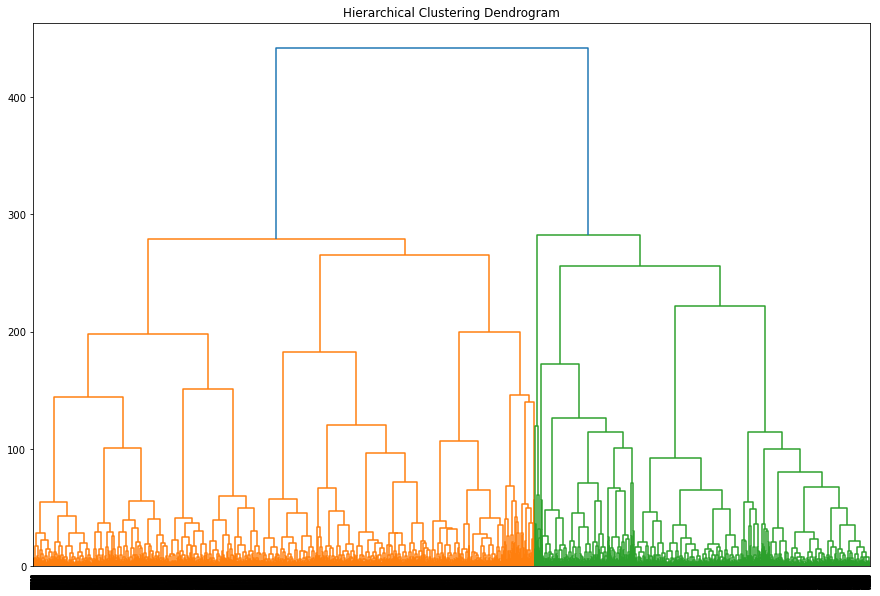

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
y_pred_agglo = model.fit(charging_sessions_scaled)

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)
plt.show()

<p> A horizontal line around at the distance 360 would result in 4 clusters. </p>
<p> We will now use the K-means algorithm to find clusters in the data set. From the dendogram we know that 4 clusters is probably a good result. However, we will validate this by applying the 'elbow' method. </p>

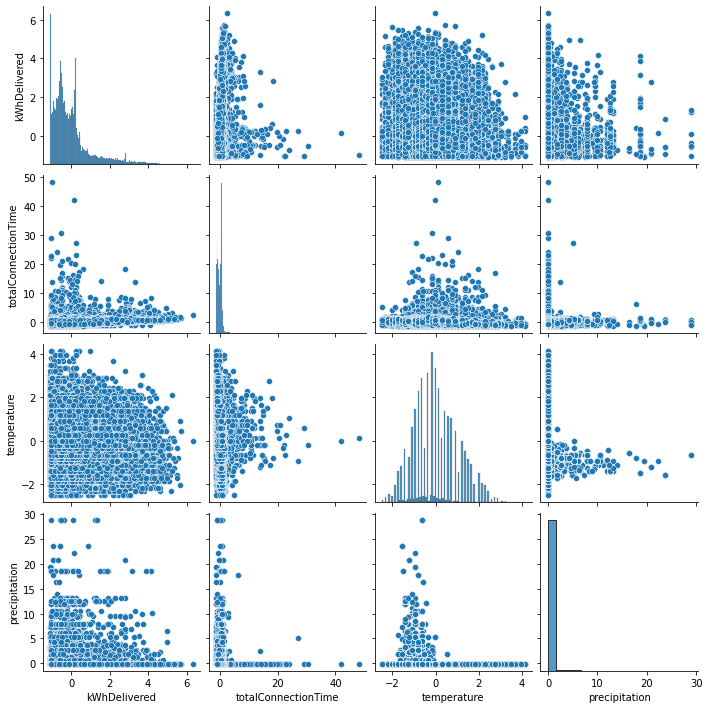

In [ ]:
sns.pairplot(data=df_charging_sessions_scaled)

In [ ]:
# defining the max number of clusters
k_max = 40

# aplying k-means iteratively to figure out the best k
clusters = []
losses = []

for k in range(k_max):
    kmeans_model = KMeans(n_clusters=k+1)
    kmeans_model.fit(charging_sessions_scaled)
    clusters.append(k+1)
    losses.append(kmeans_model.inertia_)

In [ ]:
print(losses)

[224507.99999999945, 175341.58524911368, 134991.4527009002, 105084.2239004297, 88567.48230613182, 76160.3010859284, 67970.18219643645, 60159.42160965965, 55526.859153449645, 51945.98223119511, 47967.94921675936, 45048.97534304136, 41346.19986472613, 39222.30802573061, 37241.02824387862, 35189.01152355963, 33248.97871061765, 31809.289863682086, 30659.927586964757, 29718.749939934864, 28299.930817569253, 27467.136840507086, 26435.481675620158, 25643.719992757076, 24942.339586630274, 24232.720679499795, 23303.408725775687, 22751.955983482338, 22191.973013141418, 21755.18175882089, 21006.090942743638, 20518.3987983035, 19989.091632645424, 19635.137013747648, 19031.762993218174, 18760.201828850295, 18396.767292024346, 18229.037286280556, 17632.583480749126, 17278.73903082]


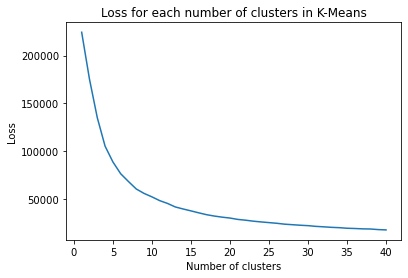

In [ ]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.title("Loss for each number of clusters in K-Means")
plt.show()

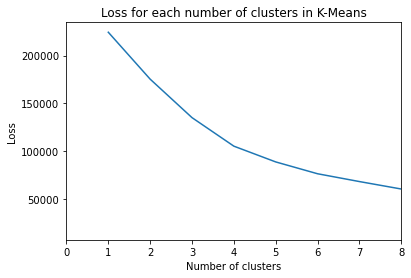

In [ ]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.title("Loss for each number of clusters in K-Means")
plt.xlim([0,8])
plt.show()

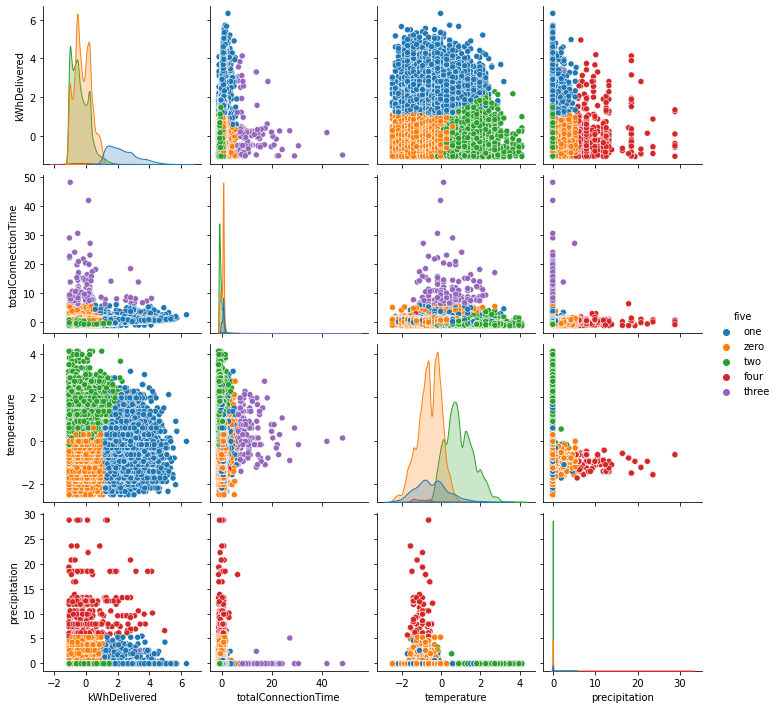

In [ ]:
numbers = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight"]

five_means = KMeans(n_clusters=5)
five_means.fit(charging_sessions_scaled)
df_charging_sessions_scaled["five"] = five_means.predict(charging_sessions_scaled)
df_charging_sessions_scaled["five"] = df_charging_sessions_scaled["five"].apply(lambda x: numbers[x])
sns.pairplot(data=df_charging_sessions_scaled, hue="five")

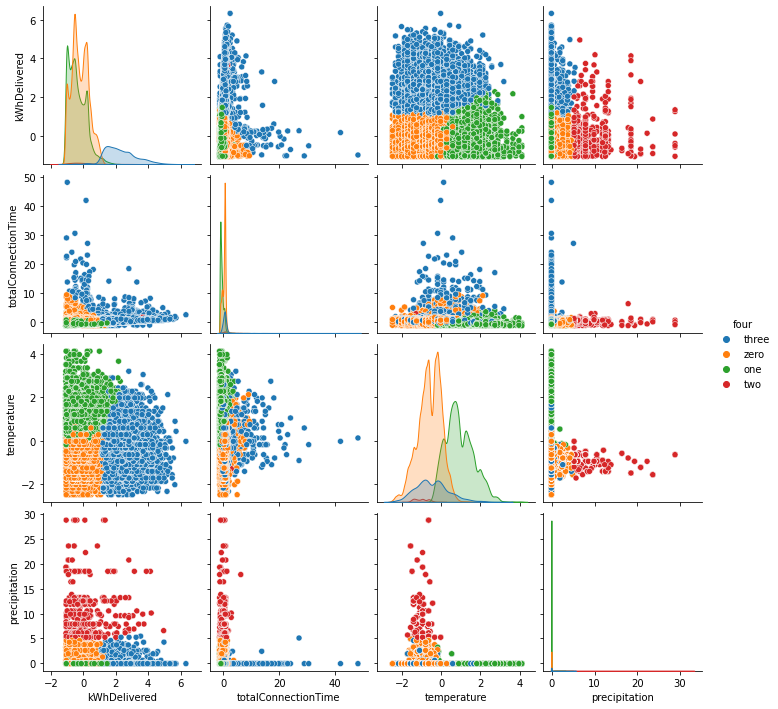

In [ ]:
numbers = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight"]

four_means = KMeans(n_clusters=4)
four_means.fit(charging_sessions_scaled)
df_charging_sessions_scaled["four"] = four_means.predict(charging_sessions_scaled)
df_charging_sessions_scaled["four"] = df_charging_sessions_scaled["four"].apply(lambda x: numbers[x])
sns.pairplot(data=df_charging_sessions_scaled, hue="four")

The optimal number of clusters seems to be in the range of 8 to 12. Due to the result of the hierarichal clustering, 8 appears to be a good choice.

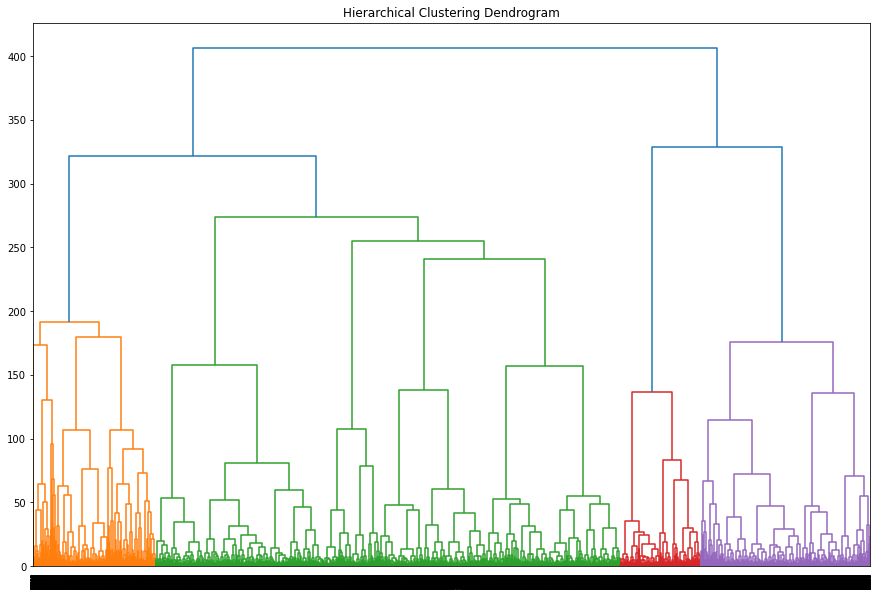

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
y_pred_agglo = model.fit(charging_sessions_scaled)

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)
plt.show()

- sessions aggregieren
- literatur nachgucken